# Exploring the Risk Classification of Business Firms Based on Discrepancies in Past Audits

### **Introduction**

Audit is defined as the process of evaluating a business’s financial statements to ensure that these records concur with the expectations of standard accounting laws. The ability to detect fraudulent activity in a firm (i.e. a business) which may warrant an audit is essential to modern-day, efficient audit management. In this investigation, we will attempt to answer a **predictive** question with **classification** based on various audit risk factors: Given a firm’s amount of money involved in misstatements in past audits (“Money_Value” [Crore]) and total amount of discrepancies found in other reports (“TOTAL” [Crore]), can we accurately predict a firm’s appropriate Risk Class: “Fraud” or “No-fraud?” 

The “Audit Data” dataset will be used to answer this question. This dataset contains various predictors about 777 Indian firms over a one-year period from 2015 to 2016, cataloging past and present historical audit risk factors. A classification model can be built upon these two selected factors to predict and identify potentially fraudulent firms.

To expand upon our selected predictors: the variable “TOTAL” represents the total amount of discrepancies found in other reports (i.e. the sum of “PARA_A” and “PARA_B” scores, which are discrepancies in planned and unplanned expenditures, respectively). The variable “Money_Value” represents the amount of money involved in misstatements of past audits. Both of these indicators deal with firms’ past mismanaged or missing money and, as such, we feel they make excellent predictors for the classification of Risk Class. Risk Class is a binary categorical variable where the “Fraud” class is represented by “Risk = 1” and the “No-fraud” class is represented by “Risk = 0.” In context, firms that fall within the “Fraud” class are considered to warrant significant investigation. If a future firm were to be examined, by looking at their past audits and discrepancies through the model proposed herein, we can classify it as a potential “Fraud” or “No-Fraud” Risk. 


### **Exploratory Data Analysis**

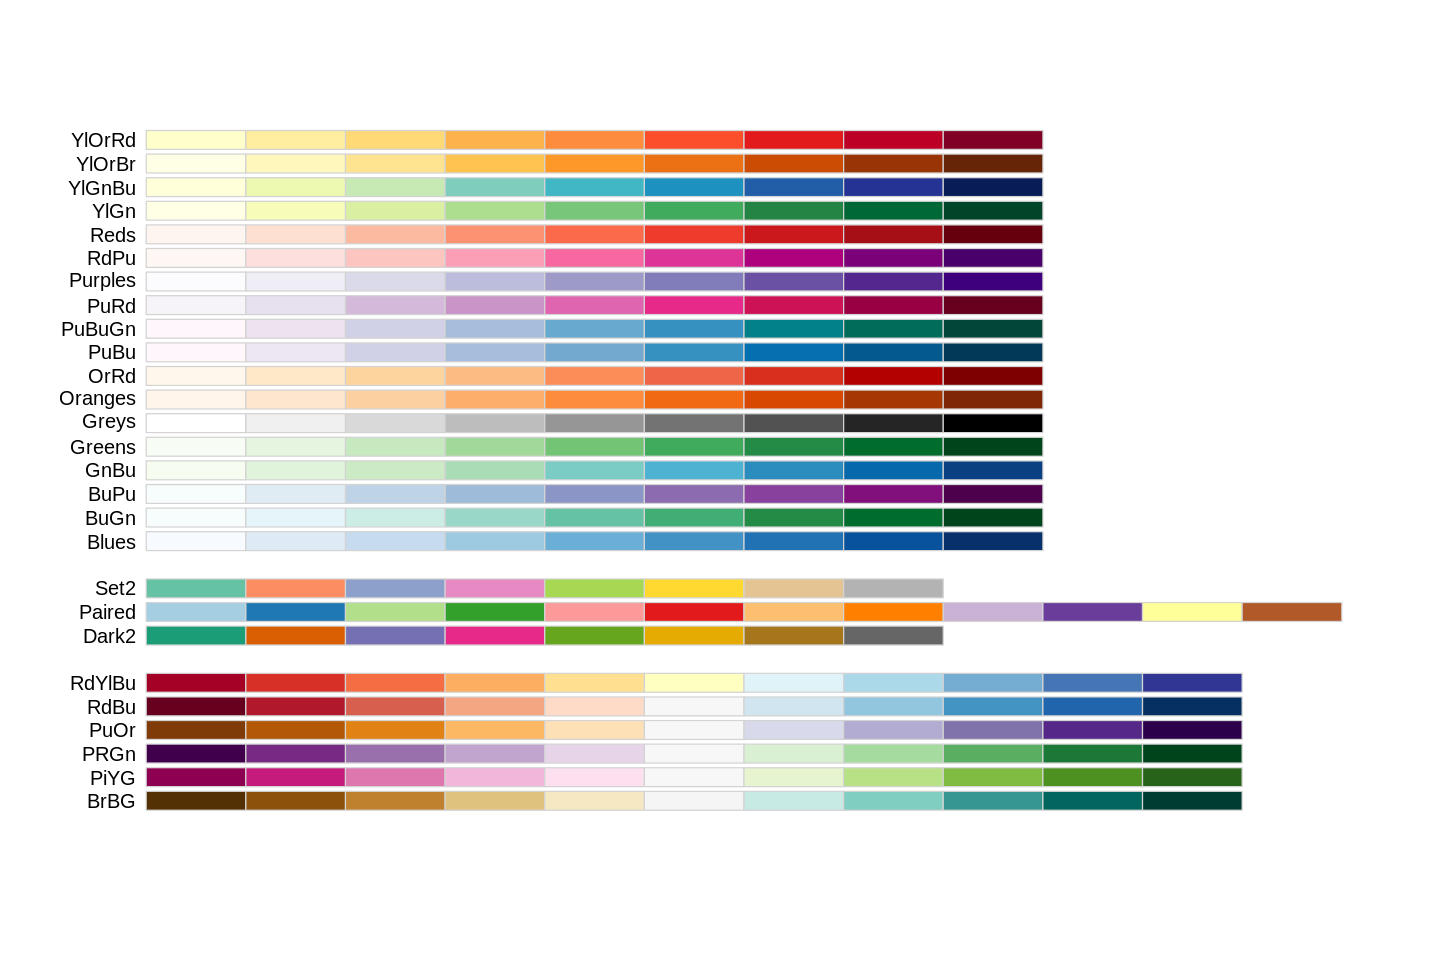

In [6]:
library(tidyverse)
library(repr)
library(tidymodels)
library(scales)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)
# Ensure the Palette used is colour blind friendly
display.brewer.all(colorblindFriendly = TRUE)

Parsed with column specification:
cols(
  Sector_score = col_double(),
  LOCATION_ID = col_character(),
  PARA_A = col_double(),
  SCORE_A = col_double(),
  PARA_B = col_double(),
  SCORE_B = col_double(),
  TOTAL = col_double(),
  numbers = col_double(),
  Marks = col_double(),
  Money_Value = col_double(),
  MONEY_Marks = col_double(),
  District = col_double(),
  Loss = col_double(),
  LOSS_SCORE = col_double(),
  History = col_double(),
  History_score = col_double(),
  Score = col_double(),
  Risk = col_double()
)

`summarise()` ungrouping output (override with `.groups` argument)



Risk,count,percentage
<chr>,<int>,<dbl>
Fraud,486,62.62887
No Fraud,290,37.37113


Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


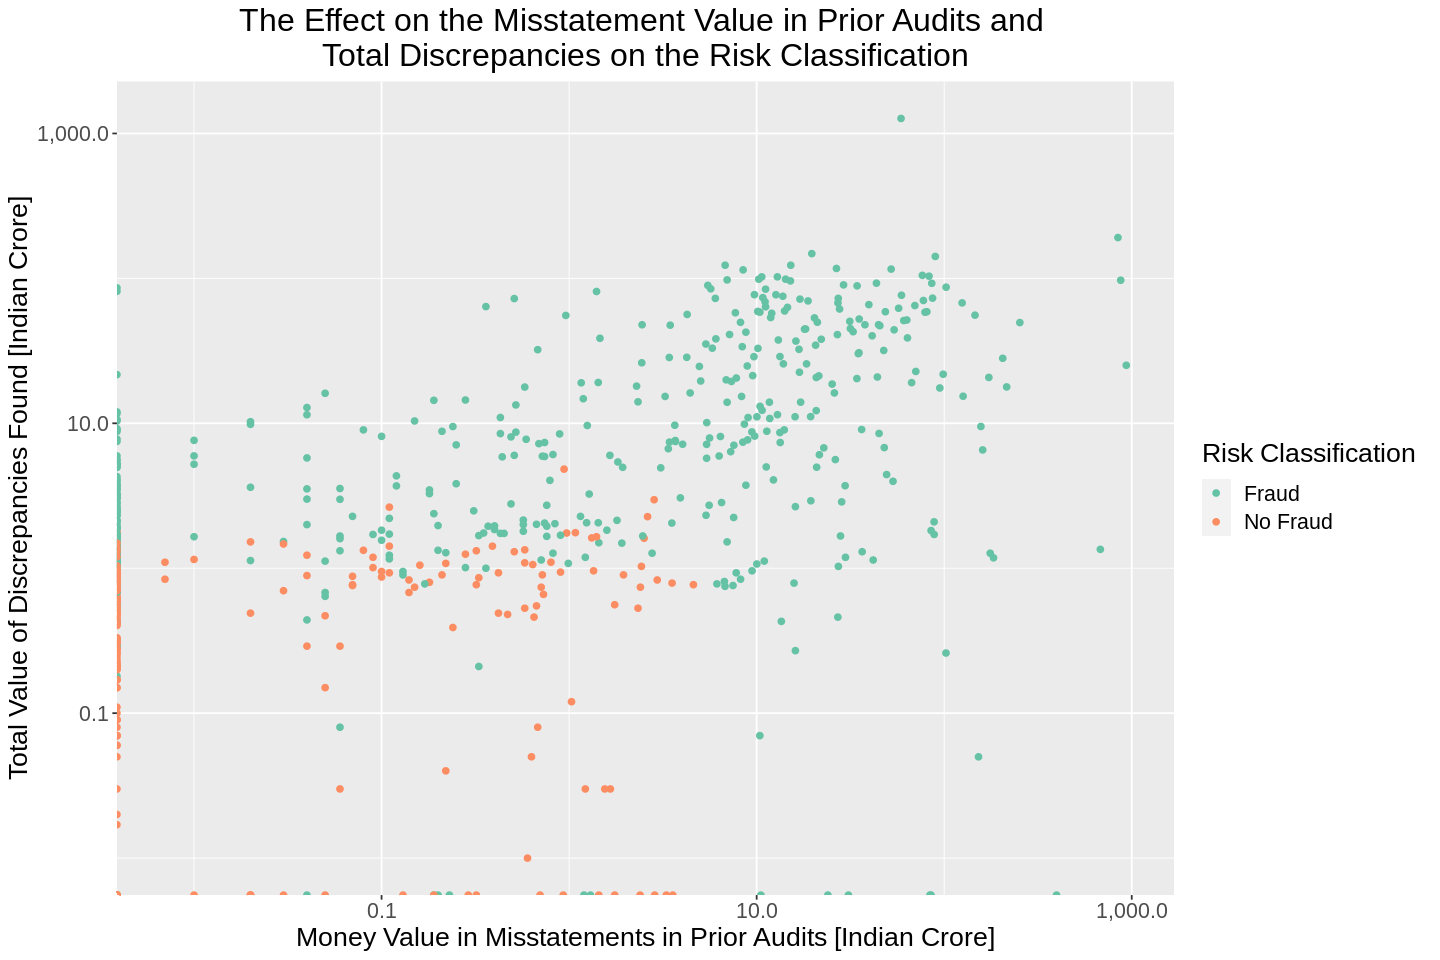

In [7]:
# Loading the Dataset
url = "https://raw.githubusercontent.com/fulleraltamiranoe/audit_data/main/trial.csv"
audit_trial_data <- read_csv(url) %>%
    mutate(Risk = as_factor(Risk))

# Changing the Risk Classification to meaningful names
audit_trial_data$Risk <- ifelse(audit_trial_data$Risk == "1", "Fraud", "No Fraud")

# Group by Risk and Summarize to see how the Risk classification is ditributed
count <- audit_trial_data %>%
    group_by(Risk) %>%
    summarize(count = n(), percentage = n() / nrow(audit_trial_data) * 100)
count

# Visualizing original data utilizing a log scale
options(repr.plot.width = 12, repr.plot.height = 8) 
audit_original_plot <- audit_trial_data %>%
    ggplot(aes(x = Money_Value, y = TOTAL, colour = Risk)) +
    geom_point() +
    labs(x = "Money Value in Misstatements in Prior Audits [Indian Crore]", 
         y = "Total Value of Discrepancies Found [Indian Crore]", 
         colour = "Risk Classification") +
    ggtitle("The Effect on the Misstatement Value in Prior Audits and \nTotal Discrepancies on the Risk Classification") +
    theme(text = element_text(size = 16), plot.title = element_text(hjust = 0.5)) +
    scale_x_log10(labels = label_comma()) +
    scale_y_log10(labels = label_comma()) +
    scale_color_brewer(palette = "Set2")
audit_original_plot


In [8]:
# Set seed to ensure randomness
set.seed(1001)

# Cleaning the dataset and keeping predictors we will use
# From the above visualization, we can see that all firms with a Money_Value and a TOTAL 
# equaling more than 10 were classified as Fraud, so they are not useful in our analysis
audit <- audit_trial_data %>%
    select(Money_Value, TOTAL, Risk) %>%
    filter(Money_Value < 10, TOTAL < 10)
audit

# Splitting data into training and testing sets 
audit_split <- initial_split(audit, prop = 0.8, strata = Risk)  
audit_train <- training(audit_split)   
audit_test <- testing(audit_split)

# # Count the number of instances of Fraudulent (Risk = 1) vs non-Fraudulent (Risk = 0) firms
# # in our training data (they seem about evenly distributed)
count_training <- audit_train %>%
    group_by(Risk) %>%
    summarize(count = n(), percentage = n() / nrow(audit_train) * 100)
count_training

Money_Value,TOTAL,Risk
<dbl>,<dbl>,<chr>
3.38,6.68,Fraud
0.94,4.83,No Fraud
0.00,0.74,No Fraud
⋮,⋮,⋮
0.00,0.28,No Fraud
0.00,0.20,No Fraud
0.32,0.00,No Fraud


`summarise()` ungrouping output (override with `.groups` argument)



Risk,count,percentage
<chr>,<int>,<dbl>
Fraud,218,48.44444
No Fraud,232,51.55556


Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


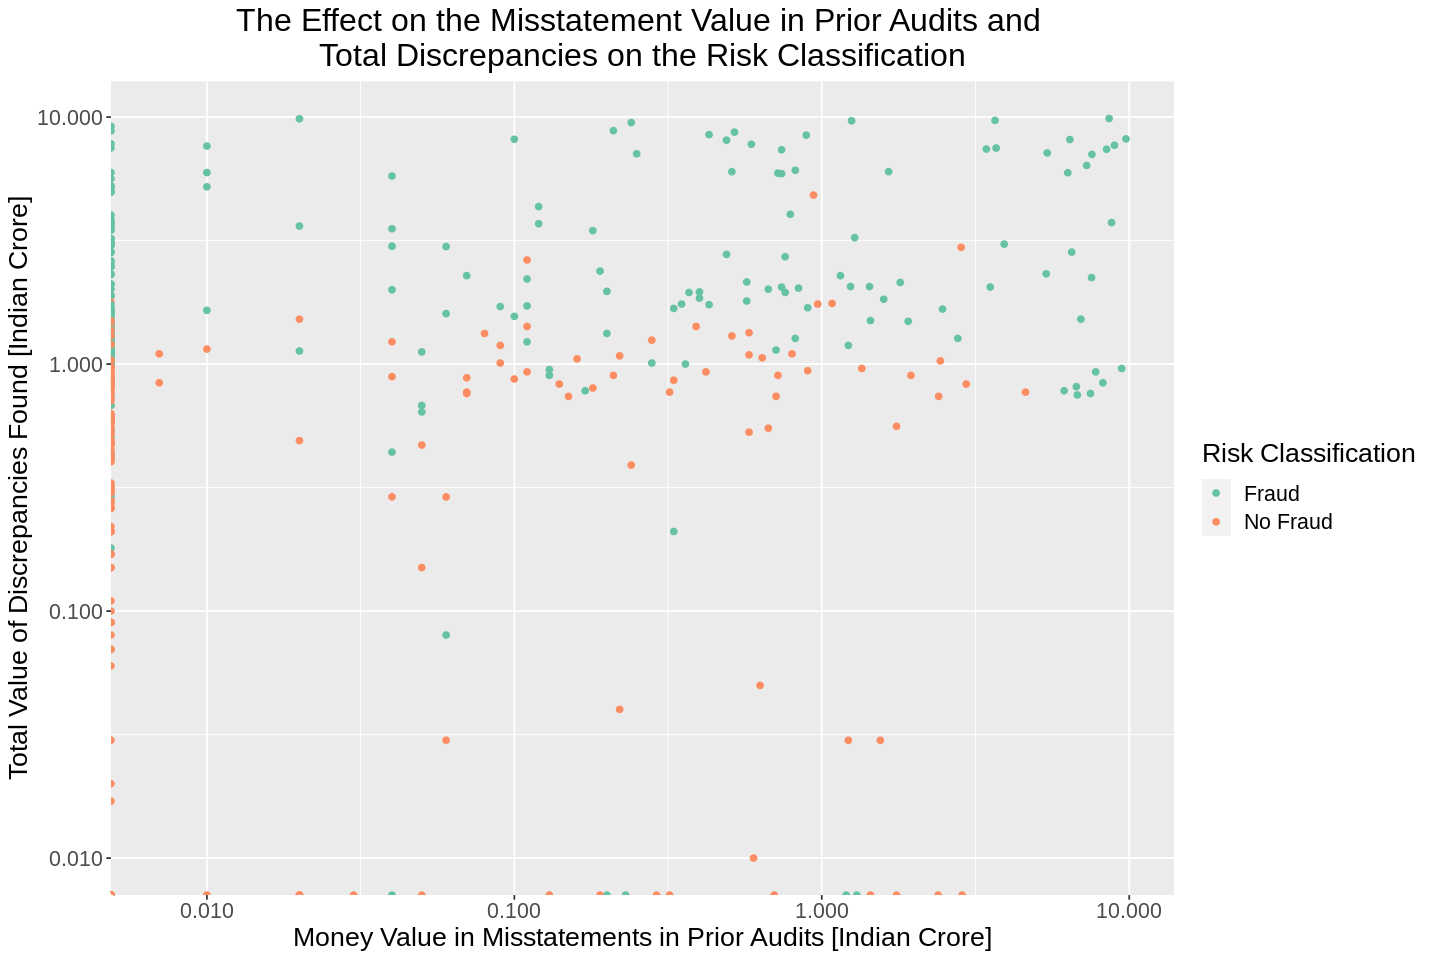

In [9]:
# Creating a scatterplot of Money_Value and TOTAL using a logarithmic scale
# with our training data set
options(repr.plot.width = 12, repr.plot.height = 8) 
audit_training_plot <- audit_train %>%
    ggplot(aes(x = Money_Value, y = TOTAL, colour = Risk)) +
    geom_point() +
      labs(x = "Money Value in Misstatements in Prior Audits [Indian Crore]", 
         y = "Total Value of Discrepancies Found [Indian Crore]", 
         colour = "Risk Classification") +
    ggtitle("The Effect on the Misstatement Value in Prior Audits and \nTotal Discrepancies on the Risk Classification") +
    theme(text = element_text(size = 16), plot.title = element_text(hjust = 0.5)) +
    scale_x_log10(labels = label_comma()) +
    scale_y_log10(labels = label_comma()) +
    scale_color_brewer(palette = "Set2")

audit_training_plot

### **Methods**

In order to predict the Risk Class category of firms, the K-nearest neighbours classification algorithm will be used. A model specification will be specified by adjusting for the number of neighbours based on the accuracy estimate, ensuring the utilization of scaled data, and the straight-line distance. 

The specification will then be fitted with the training data set and Risk specified as the target utilizing both “TOTAL” and “Money_Value” as predictors. 

Note that the risk classification of “Fraud” (Risk = 1) is vastly over-represented in the original data. Creating a recipe to oversample the “No Fraud” (Risk = 0) classification could get around this. What has been done so far for the purposes of this preliminary analysis is to filter out any value over 10 for both “TOTAL” and “Money_Value” as it was noticed in the original data that all of these values were classified as “Fraud”. This also ensured that the training and testing datasets had a similar number of both classifications. 


To visualize the results, hypothetical examples of new firms with new discrepancy values will be overlaid in our visualization above to test the effectiveness of our model.

### **References**

Nishtha Hooda, Seema Bawa & Prashant Singh Rana (2018) Fraudulent Firm Classification: A Case Study of an External Audit, Applied Artificial Intelligence, 32:1, 48-64, DOI: 10.1080/08839514.2018.1451032